In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from activephasemap.simulators import UVVisExperiment
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [2]:
ITERATION = 14
design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]
expt = UVVisExperiment(design_space_bounds, "../data/")
expt.read_iter_data(ITERATION)
expt.generate(use_spline=True)

grid_data = np.load("./data/grid_data_10_%d.npz"%ITERATION)
comps = grid_data["comps"]
spectra = grid_data["spectra"][:,:,0]

Loading data from iteration 0 with shapes: (12, 2) (12, 101)
Loading data from iteration 1 with shapes: (6, 2) (6, 101)
Loading data from iteration 2 with shapes: (6, 2) (6, 101)
Loading data from iteration 3 with shapes: (6, 2) (6, 101)
Loading data from iteration 4 with shapes: (6, 2) (6, 101)
Loading data from iteration 5 with shapes: (6, 2) (6, 101)
Loading data from iteration 6 with shapes: (6, 2) (6, 101)
Loading data from iteration 7 with shapes: (6, 2) (6, 101)
Loading data from iteration 8 with shapes: (6, 2) (6, 101)
Loading data from iteration 9 with shapes: (6, 2) (6, 101)
Loading data from iteration 10 with shapes: (6, 2) (6, 101)
Loading data from iteration 11 with shapes: (6, 2) (6, 101)
Loading data from iteration 12 with shapes: (6, 2) (6, 101)
Loading data from iteration 13 with shapes: (6, 2) (6, 101)


In [3]:
fitted_params = np.ones((comps.shape[0], 8))
param_names =  ["label", "r_sphere_mu", "r_sphere_sigma", "em_sphere", "ar_mu", "ar_sig", "em_rod", "w"]
parameters_bounds = [(0, 2), #label
                     (2.0, 50.0), # sphere radius (mu)
                     (0.001, 0.4), # sphere radius (sigma)
                     (1.0, 10), # dieletric constant for sphereical medium
                     (1.1, 5.0), # nanorod aspect ratio (mu)
                     (0.001, 0.4), # nanorod aspect ratio (sigma)
                     (1.0, 10.0), # dieletric constant for nanorod medium
                     (0.0, 1.0), # mixed model weights
                     ]
for i in range(comps.shape[0]):
    try:
        result = np.load("./mie/results_grid/res_%d.npz"%i)
        fitted_params[i,0] = result["feats"]
        fitted_params[i, 1:] = result["best_X"]
    except FileNotFoundError:
        fitted_params[i,:] = np.array([0, 4.0, 0.0, 1.33, 1.0, 0.0, 1.0, 1.0])
        

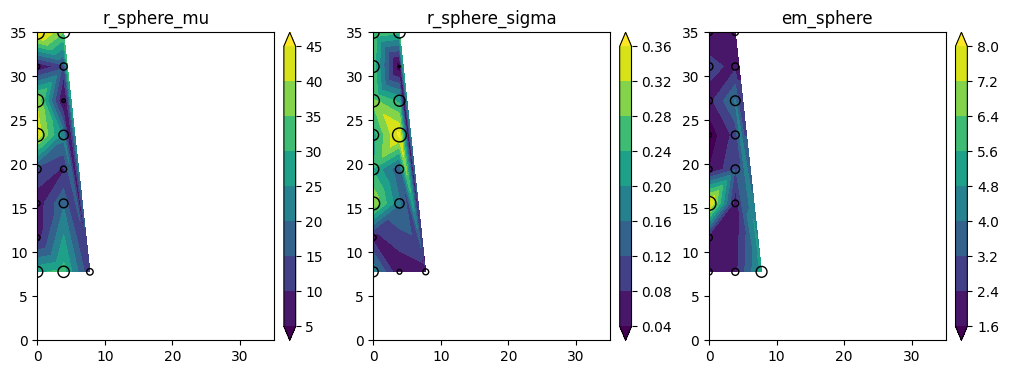

In [4]:
# Plot sphere parameters
flags = fitted_params[:,0]==1
param_indices = [1, 2, 3]
fig, axs = plt.subplots(1,3, figsize=(3*4, 1*4))
fig.subplots_adjust(wspace=0.3)
axs = axs.flatten()
for i, ax in enumerate(axs):
    param_values = fitted_params[flags, param_indices[i]]
    mappable = ax.tricontourf(comps[flags,0], 
                   comps[flags,1],
                   param_values,
                   levels=10,
                   extend='both'
                )
    
    norm_param_values = param_values/max(param_values)
    ax.scatter(comps[flags,0], 
               comps[flags,1], 
               s=100*norm_param_values, 
               edgecolor='k', 
               facecolors='none'
               )    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    ax.set_title(param_names[param_indices[i]])
    ax.set_xlim([expt.bounds[0,0], expt.bounds[1,0]])
    ax.set_ylim([expt.bounds[0,1], expt.bounds[1,1]])
plt.show()

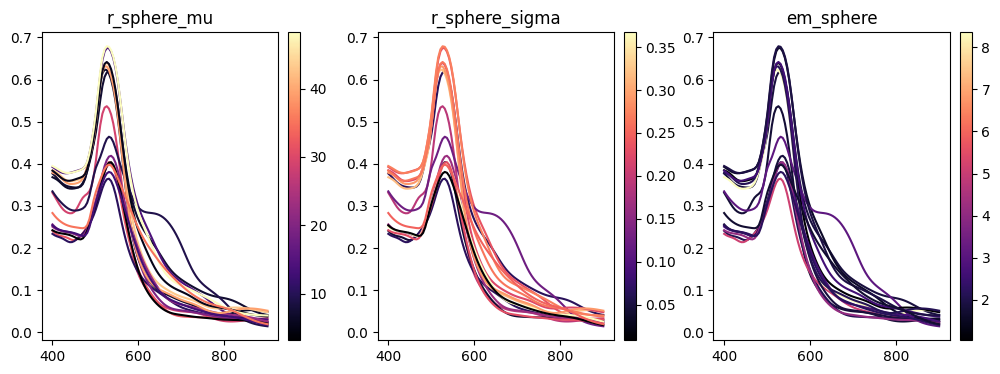

In [5]:
flags = fitted_params[:,0]==1
sphere_ids = np.argwhere(flags).squeeze()

param_indices = [1, 2, 3]
fig, axs = plt.subplots(1,3, figsize=(3*4, 1*4))
fig.subplots_adjust(wspace=0.3)
axs = axs.flatten()
for i, ax in enumerate(axs):
    color_param = fitted_params[flags, param_indices[i]]

    cmap = colormaps["magma"]
    norm = Normalize(vmin=min(color_param), vmax = max(color_param))
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    for j,k in enumerate(sphere_ids):
        ax.plot(expt.wl, 
                spectra[k,:], 
                c = cmap(norm(color_param[j]))
                )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    ax.set_title(param_names[param_indices[i]])
plt.show()

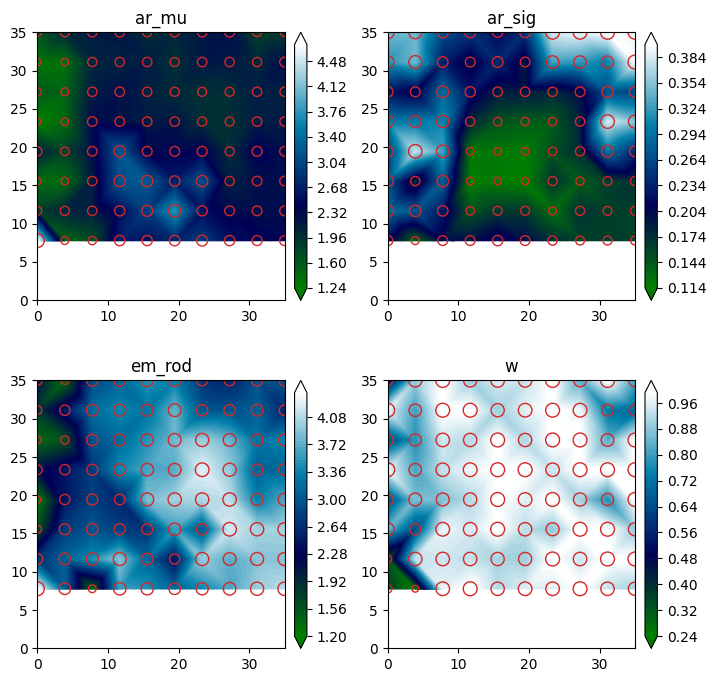

In [6]:
# Plot nanorod parameters
flags = ~(fitted_params[:,0]==0)
param_indices = [4, 5, 6, 7]
fig, axs = plt.subplots(2,2, figsize=(2*4, 2*4))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axs = axs.flatten()
for i, ax in enumerate(axs):
    param_id = param_indices[i]
    if not param_id==7:
        param_values = fitted_params[flags, param_id]
    else:
        param_values = 1-fitted_params[flags, param_id]
    mappable = ax.tricontourf(comps[flags,0], 
                   comps[flags,1],
                   param_values,
                   levels=100,
                   extend='both',
                   alpha=1.0,
                   antialiased=True,
                   cmap="ocean"
                )
    mappable.set_edgecolor("face")
    norm_param_values = param_values/max(param_values)
    ax.scatter(comps[flags,0], 
               comps[flags,1], 
               s=100*norm_param_values, 
               edgecolor='tab:red', 
               facecolors='none'
               )    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    ax.set_title(param_names[param_id])
    ax.set_xlim([expt.bounds[0,0], expt.bounds[1,0]])
    ax.set_ylim([expt.bounds[0,1], expt.bounds[1,1]])
plt.show()

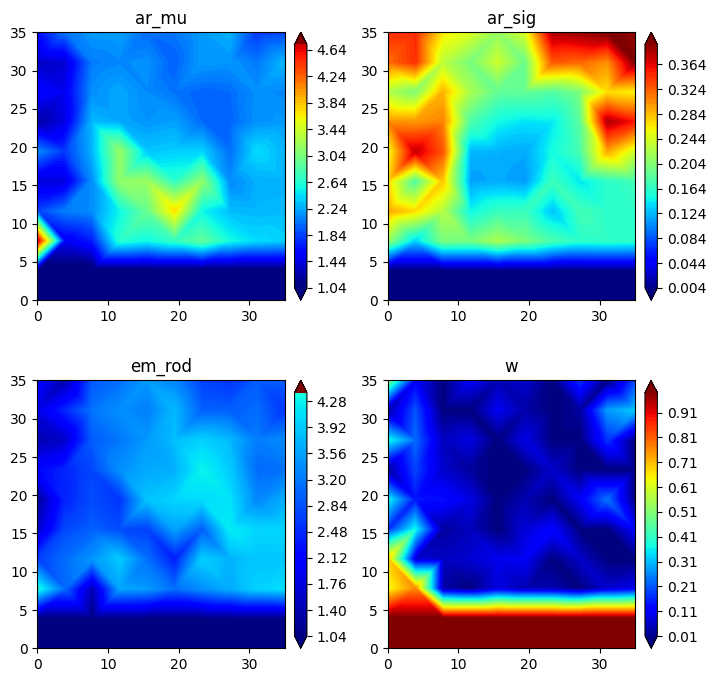

In [7]:
param_indices = [4, 5, 6, 7]
fig, axs = plt.subplots(2,2, figsize=(2*4, 2*4))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axs = axs.flatten()
for i, ax in enumerate(axs):
        param_id = param_indices[i]
        norm = Normalize(vmin=parameters_bounds[param_id][0], 
                         vmax = parameters_bounds[param_id][1]) 
        cmap = "jet"
        param_values = fitted_params[:, param_id]
        mappable = ax.tricontourf(comps[:,0], 
                                comps[:,1],
                                param_values,
                                levels=100,
                                extend='both',
                                alpha=1.0,
                                antialiased=True,
                                cmap=cmap,
                                norm = norm
                )
        mappable.set_edgecolor("face")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        cbar = fig.colorbar(mappable, cax=cax)
        ax.set_title(param_names[param_id])
        ax.set_xlim([expt.bounds[0,0], expt.bounds[1,0]])
        ax.set_ylim([expt.bounds[0,1], expt.bounds[1,1]])
plt.show()

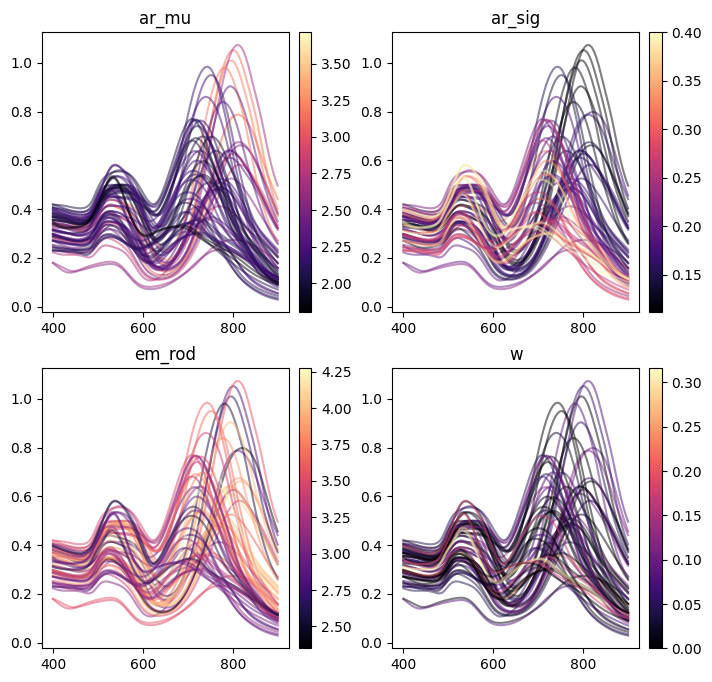

In [8]:
flags = fitted_params[:,0]==2
rod_ids = np.argwhere(flags).squeeze()

param_indices = [4, 5, 6, 7]
fig, axs = plt.subplots(2,2, figsize=(2*4, 2*4))
fig.subplots_adjust(wspace=0.3)
axs = axs.flatten()
for i, ax in enumerate(axs):
    color_param = fitted_params[flags, param_indices[i]]

    cmap = colormaps["magma"]
    norm = Normalize(vmin=min(color_param), vmax = max(color_param))
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    for j,k in enumerate(rod_ids):
        ax.plot(expt.wl, 
                spectra[k,:], 
                c = cmap(norm(color_param[j])),
                alpha=0.5
                )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    ax.set_title(param_names[param_indices[i]])
plt.show()

### Make paper plot

In [9]:
def prettify_axis(ax):
    ax.set_xlabel(r"Silver Nitrate ($10^{-4}$ M)")
    ax.set_ylabel(r"Ascorbic Acid ($10^{-3}$ M)")
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

    SN_labels = [item.get_text() for item in ax.get_xticklabels()]
    SN_vol_to_conc = lambda v : (6.4*v)/(300)
    SN_conc_labels = []
    for l in SN_labels:
        SN_conc_labels.append("%.2f"%SN_vol_to_conc(float(l)))
    ax.set_xticklabels(SN_conc_labels)

    AA_labels = [item.get_text() for item in ax.get_yticklabels()]
    AA_vol_to_conc = lambda v : (6.3*v)/(300)
    AA_conc_labels = []
    for l in AA_labels:
        AA_conc_labels.append("%.2f"%AA_vol_to_conc(float(l)))
    ax.set_yticklabels(AA_conc_labels)

    return ax

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1102/951585302.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1102/951585302.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1102/951585302.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1102/951585302.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)
/var/folders/84/

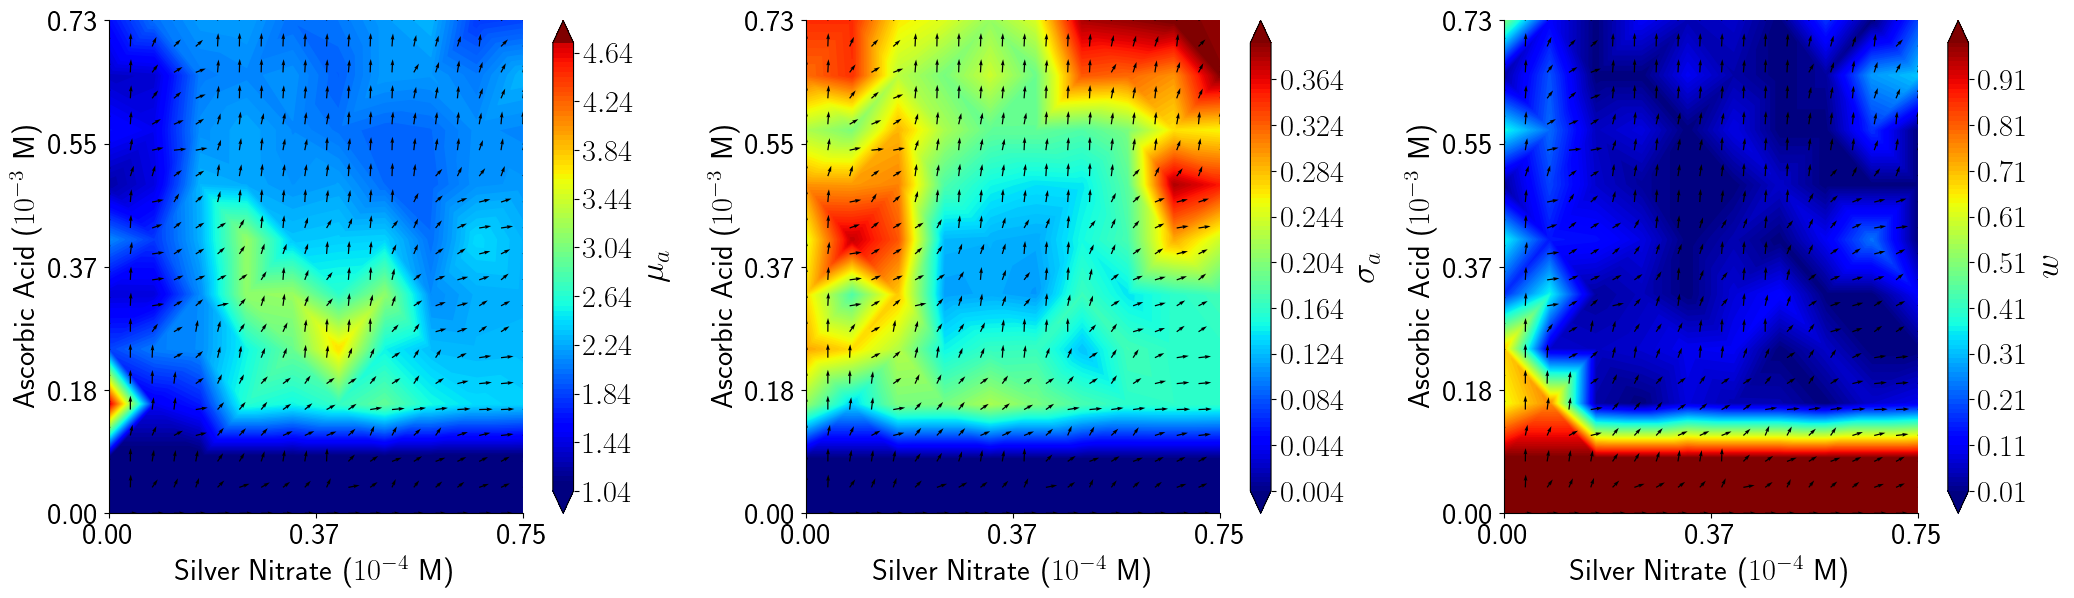

In [10]:
gradient_data = np.load("./data/gradient_data.npz")

grid_grad = gradient_data["grid_grad"]
grid_norm = gradient_data["grid_norm"]
grid_data = np.load("./data/grid_data_20.npz")
grid_comps = grid_data["comps"]
U = grid_grad[:,0]
V = grid_grad[:,1]
# Normalize the arrows:
U = U / (grid_norm+1e-3) 
V = V / (grid_norm+1e-3)
with plt.style.context(pyplot_style):
        fig, axs = plt.subplots(1,3, figsize=(3*8, 0.8*8))
        fig.subplots_adjust(wspace=0.5)
        flags = fitted_params[:,0]==2
        param_indices = [4, 5, 7]
        param_names = ["$\mu_{a}$", "$\sigma_{a}$", "$w$"]
        for i, param_id in enumerate(param_indices):
                norm = Normalize(vmin = parameters_bounds[param_id][0],
                                 vmax = parameters_bounds[param_id][1]) 
                cmap = "jet"
                param_values = fitted_params[:, param_id]
                mappable = axs[i].tricontourf(comps[:,0], 
                                comps[:,1],
                                param_values,
                                levels=100,
                                extend='both',
                                alpha=1.0,
                                antialiased=True,
                                cmap=cmap,
                                norm = norm
                        )
                mappable.set_edgecolor("face")
                divider = make_axes_locatable(axs[i])
                cax = divider.append_axes('right', size='5%', pad=0.3)
                cbar = fig.colorbar(mappable, cax=cax)
                cbar.ax.set_ylabel(param_names[i], rotation=90, fontsize=25)
                axs[i].quiver(grid_comps[:,0], 
                        grid_comps[:,1], 
                        U, 
                        V, 
                        color="k",
                        units='width'
                        )
                prettify_axis(axs[i])
        # plt.savefig("./figures/gradient_mie_fits_compare.png")
        plt.show()


In [15]:
fitted_params[30,:]

array([1.        , 7.36047744, 0.06548295, 1.89343495, 1.83980176,
       0.29281628, 2.67420843, 0.68710898])